# Qiskit Aer: Pulse simulation on a user-defined system model

## Introduction

This notebook shows how to use the Aer pulse simulator, which simulates an OpenPulse `Schedule` on a quantum system at the Hamiltonian level.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, root

from qiskit import IBMQ
import qiskit
from qiskit.visualization.bloch import Bloch

# for constructing and specifying pulse experiments
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

# system model object
from qiskit.providers.aer.openpulse.pulse_system_model import PulseSystemModel

# function for construct transmon device models
from qiskit.providers.aer.openpulse.duffing_model_generators import duffing_system_model

## Models of pulse devices

A physical model is stored in a `PulseSystemModel` object. This object stores information required to simulate a physical system with pulse instructions.

### Generating Duffing models

The function `duffing_system_model` constructs a `PulseSystemModel` for a transmon system specified in terms of individual qubit terms, and a coupling map with coupling strenghts.

Each single transmon is specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which results in the Hamiltonian terms:
\begin{equation}
    \pi(2\nu - \alpha)a^\dagger a + \pi \alpha (a^\dagger a)^2 + 2 \pi r (a + a^\dagger) \times D(t),
\end{equation}
where $D(t)$ is the drive signal for the qubit.

Specifying a coupling for transmon pair $(l,k)$ with coupling strength $j$, results in the exchange coupling Hamiltonian term:
\begin{equation}
    2 \pi j (a_l \otimes a_k^\dagger + a_l^\dagger \otimes a_k).
\end{equation}

Finally, control channels are generated for doing cross-resonance drives between each pair of coupled transmons.

Below is an example of the construction of a $2$ transmon model with dimension cut off $3$.

In [23]:
# cutoff dimensions
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.003e9)
coupling_dict = {(0,1): 0.002e9}

# time 
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

The returned items is a `PulseSystemModel` object, a representation of a physical system specified by the above parameters, consumable by the simulator.

This object contains information about the Hamiltonian, as well as index information for each relevant `ControlChannel`. The function `duffing_system_model` reserves a `ControlChannel` index for a CR drive between each pair of coupled qubits. To access this index, call the method `control_channel_index` with a `tuple` specifying the driven and target qubits. E.g. To get the `ControlChannel` index corresponding to a CR drive on qubit 1 with target 0: 

In [26]:
two_qubit_model.control_channel_index((1,0))

1

## Example 1: Calibrating $\pi$ pulses on each qubit using Rabi experiments

In this example, we demonstrate a procedure for calibrating a $\pi$ pulse on each qubit using the simulator and the model specified in the previous code cell. For a given qubit, a sequence of experiments is run: each experiment consists of a Gaussian pulse on the qubit, followed by a measurement. In the sequence, each experiment has a subsequently larger amplitude for the Gaussian pulse. By analyzing the measurement data, we can find the amplitude at which the qubit completely flips from the ground state to the first excited state.

### Functions to generate the Rabi experiment list, and analyze the output

First, we define functions which will allow us to run a Rabi experiment and analyze the data on either qubit in `two_transmon_model`.

First, we define a function `rabi_experiments` which, given a qubit index, returns a list of `Schedules` comprising the experiments to observe a Rabi oscillation. 

In [27]:
# Do a Rabi experiment with various numbers of drive amplitudes
exp_num = 41
drive_amps = np.linspace(0, 0.9, exp_num)

# Number of shots for each experiment for collecting measurement statistics
shots = 512

# Properties of the drive pulses
drive_samples = 128
drive_sigma = 16

# Specify a measurement pulse and acquire commands to be used in all subsequent experiments
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='meas_pulse')
acq_cmd=pulse.Acquire(duration=meas_samples)
acquire_channels = [pulse.AcquireChannel(0), pulse.AcquireChannel(1)]
memoryslots = [pulse.MemorySlot(0), pulse.MemorySlot(1)]

# generate Schedules corresponding to Rabi experiments on the specified qubit 
def rabi_experiments(qubit):
    
    # create measurement schedule
    measure_and_acquire = meas_pulse(pulse.MeasureChannel(qubit)) | acq_cmd(acquire_channels, memoryslots)

    # Create schedule
    schedules = []
    for ii, drive_amp in enumerate(drive_amps):
        # drive pulse
        rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                        amp=drive_amp, 
                                        sigma=drive_sigma, name='rabi_pulse_%d' % ii)

        # add commands to schedule
        schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)

        schedule += rabi_pulse(pulse.DriveChannel(qubit))
        schedule += measure_and_acquire << schedule.duration

        schedules.append(schedule)
    
    return schedules

Next, we define two functions:
- `qubit_populations_from_memory` - given the results of a simulation, returns the relevant output data
- `rabi_fit_and_plot` - given the qubit index the Rabi experiment was performed on, the list of drive amplitudes used, and the simulation results, fits and plots the output data, and returns the measured amplitude yielding a $\pi$-pulse

In [28]:
# Function for extracting qubit populations from the memory
def qubit_populations_from_memory(sim_results):
    pop_data_Q0 = []
    pop_data_Q1 = []

    for exp_idx in range(exp_num):
        exp_mem = sim_results.get_memory(exp_idx)
        pop_data_Q0.append(np.real(exp_mem[0]))
        pop_data_Q1.append(np.real(exp_mem[1]))
    
    return [pop_data_Q0, pop_data_Q1]



# Function for plotting the data
def rabi_fit_and_plot(qubit_idx, drive_amps, sim_results):
    
    pop_data = qubit_populations_from_memory(sim_results)
    
    # fit the data
    fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
    fitparams, conv = curve_fit(fit_func, drive_amps, pop_data[qubit_idx], [0.5,0.5,0.6,1.5])
    
    #get the pi amplitude by finding the point at which the rabi oscillations achieve the max value 
    pi_amp = root(lambda x: fit_func(x, *fitparams) - 1, x0 = 0.5).x[0]
    
    # Plot the data
    plt.plot(drive_amps, pop_data[0], label='Q0')
    plt.plot(drive_amps, pop_data[1], label='Q1')
    plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='black', linestyle='dashed', label='Fit')
    plt.axvline(pi_amp, color='black', linestyle='dashed')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('Rabi on Q{0}'.format(str(qubit_idx)), fontsize=20)
    plt.grid(True)

    # print and return the pi amp value
    print('Pi Amplitude for qubit {0}: {1}'.format(str(qubit_idx),str(pi_amp)))
    return pi_amp

### Run and fit the Rabi experiment for qubit 0

First, get the backend.

In [29]:
# get the pulse simulator backend
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

Next, assemble the qobj for Rabi experiments on qubit 0. Here, we want to automatically compute the qubit frequencies from the Hamiltonian.

In [30]:
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj for a rabi experiment on qubit 0, passing the simulator as the backend
rabi_Q0_qobj = assemble(rabi_experiments(qubit=0),
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

Pi Amplitude for qubit 0: 0.3122628921046977


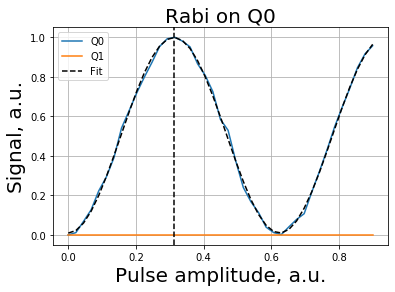

In [31]:
# run the simulation
rabi_Q0_results = backend_sim.run(rabi_Q0_qobj, two_oscillator_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q0 = rabi_fit_and_plot(0, drive_amps, rabi_Q0_results)

Plotted is the averaged counts for observing each qubit in the first excited state. Here, qubit 0 oscillates between the 0 and 1 state, whereas qubit 1, which was not driven, remains in the ground state. The amplitude at which qubit 0 is completely in the first excited state is the desired $\pi$ amplitude.

Note: The warning from the simulation is stating that the `qubit_lo_freq` is being computed from the Hamiltonian of the system, as the user did not specify one when the qobj was assembled.

### Do the same for qubit 1

Rerun the same commands for qubit 1. Here, when we `assemble`, we won't specify `qubit_lo_freq`. In this situation, the simulator will try to generate it automatically; in this case the only potential source of the local oscillator frequencies is the Hamiltonian itself, so it will automatically be computed from the drift.

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/aer/openpulse/qobj/digest.py:94: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel,              so it is beign automatically determined from the drift Hamiltonian.
  so it is beign automatically determined from the drift Hamiltonian.')


Pi Amplitude for qubit 1: 0.3105348194765702


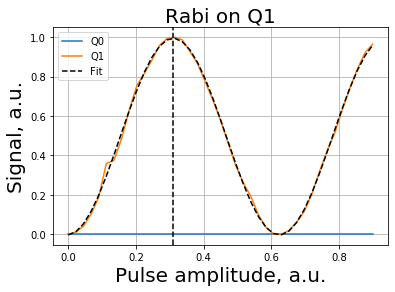

In [32]:
# assemble the qobj for a rabi experiment on qubit 1, passing the simulator as the backend
rabi_Q1_qobj = assemble(rabi_experiments(qubit=1),
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

# run the simulation
rabi_Q1_results = backend_sim.run(rabi_Q1_qobj, two_oscillator_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q1 = rabi_fit_and_plot(1, drive_amps, rabi_Q1_results)

We observe similar oscillations, with the roles of qubits 0 and 1 reversed.

## Example 2: Oscillations from cross-resonance drive

Next, we simulate the effects of a cross-resonance drive, in which a transmon is driven at the frequency of another target transmon that is coupled to it, inducing oscillations. The important phenomonen to observe here is that the oscillations and trajectory of the target qubit *depends* on the state of the driven qubit, which is precisely what is required for doing two qubit controlled quantum gates.

The set up in the experiment is the same to Example 1, but now pulses are performed on the cross-resonance control channel. We also need to observe the oscillations in two situations: when the drive qubit is in the ground state, and when it is in the first excited state. For the latter case, we need to excite the driven qubit at the beginning of the experiment. For this, we will use the calibrated $\pi$ pulses from Example 1. 

### Functions to generate the experiment list, and analyze the output

First, we define a function `cr_drive_experiments`, which, given the drive and target indices, and the option to either start with the drive qubit in the ground or excited state, returns a list of experiments for observing the oscillations.

In [33]:
# exp configuration
exps = 41
shots = 512

# Rabi pulse
cr_drive_amps = np.linspace(0, 0.9, exps)
cr_drive_samples = 600
cr_drive_sigma = 4

# create measurement schedule
measure_and_acquire = meas_pulse(pulse.MeasureChannel(0)) | acq_cmd(acquire_channels, memoryslots)

pi_amps = [pi_amp_Q0, pi_amp_Q1]

def cr_drive_experiments(drive_idx, target_idx, flip_drive_qubit = False):

    # Create schedule
    schedules = []
    for ii, cr_drive_amp in enumerate(cr_drive_amps):
        
        # pulse for flipping drive qubit if desired
        pi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=pi_amps[drive_idx], 
                                       sigma=drive_sigma, name='pi')


        # cr drive pulse
        cr_rabi_pulse = pulse_lib.gaussian_square(duration=cr_drive_samples, 
                                                  amp=cr_drive_amp, 
                                                  risefall=cr_drive_sigma*4,
                                                  sigma=cr_drive_sigma, name='rabi_pulse_%d' % ii)

        # add commands to schedule
        schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)

        # flip drive qubit if desired
        if flip_drive_qubit:
            schedule += pi_pulse(pulse.DriveChannel(drive_idx))
        
        # do cr drive
        # First, get the ControlChannel index for CR drive from drive to target
        cr_idx = two_oscillator_model.control_channel_index((drive_idx, target_idx))
        schedule += cr_rabi_pulse(pulse.ControlChannel(cr_idx))  << schedule.duration
        
        
        schedule += measure_and_acquire << schedule.duration

        schedules.append(schedule)
    return schedules

Next we create two functions for observing the data:
- `plot_cr_pop_data` - for plotting the oscillations in the same style as in Example 1
- `plot_bloch_sphere` - for viewing the trajectory of the target qubit on the bloch sphere

In [39]:
def plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result):
    amp_data_Q0 = []
    amp_data_Q1 = []

    for exp_idx in range(len(cr_drive_amps)):
        exp_mem = sim_result.get_memory(exp_idx)
        amp_data_Q0.append(np.abs(exp_mem[0]))
        amp_data_Q1.append(np.abs(exp_mem[1]))

    plt.plot(drive_amps, amp_data_Q0, label='Q0')
    plt.plot(drive_amps, amp_data_Q1, label='Q1')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('CR (Target Q{0}, driving on Q{1})'.format(target_idx, drive_idx), fontsize=20)
    plt.grid(True)

def bloch_vectors(drive_idx, drive_energy_level, sim_result):
    
    # get the dim used for simulation
    dim = int(np.sqrt(len(sim_result.get_statevector(0))))
    
    
    # get the relevant dressed state indices
    idx0 = 0
    idx1 = 0
    if drive_idx == 0:
        if drive_energy_level == 0:
            idx0, idx1 = 0, dim
        elif drive_energy_level == 1:
            idx0, idx1 = 1, dim + 1
    if drive_idx == 1:
        if drive_energy_level == 0:
            idx0, idx1 = 0, 1
        elif drive_energy_level == 1:
            idx0, idx1 = dim, dim + 1

    # construct Pauli operators for correct dressed manifold
    state0 = np.array([two_qubit_model.hamiltonian._estates[idx0]])
    state1 = np.array([two_qubit_model.hamiltonian._estates[idx1]])
    
    outer01 = np.transpose(state0)@state1
    outer10 = np.transpose(state1)@state0
    outer00 = np.transpose(state0)@state0
    outer11 = np.transpose(state1)@state1
    
    X = outer01 + outer10
    Y = -1j*outer01 + 1j*outer10
    Z = outer00 - outer11
    
    # function for computing a single bloch vector
    bloch_vec = lambda vec: np.real(np.array([np.conj(vec)@X@vec, np.conj(vec)@Y@vec, np.conj(vec)@Z@vec]))
    
    return [bloch_vec(sim_result.get_statevector(idx)) for idx in range(len(sim_result.results))]

def plot_bloch_sphere(bloch_vectors):
    sphere = Bloch()
    sphere.add_points(np.transpose(bloch_vectors))
    sphere.show()

## Drive qubit 1 to observe CR oscillations on qubit 0

First, we drive with both qubit 0 and qubit 1 in the ground state.

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/aer/openpulse/qobj/digest.py:94: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel,              so it is beign automatically determined from the drift Hamiltonian.
  so it is beign automatically determined from the drift Hamiltonian.')


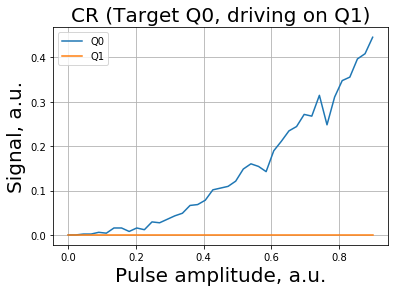

In [40]:
drive_idx = 1
target_idx = 0
flip_drive = False

cr_rabi_qobj = assemble(cr_drive_experiments(drive_idx, target_idx, flip_drive),
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result)

Observe that qubit 1 remains in the ground state, while excitations are driven in qubit 0.

Next, plot qubit 1s trajectory on the Bloch sphere:

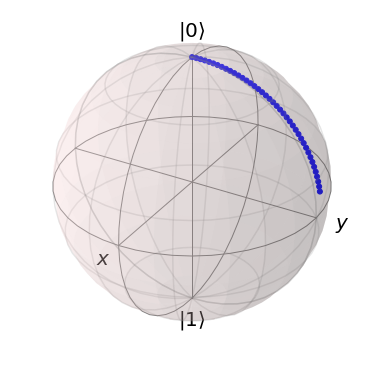

In [41]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

Next, we again perform a CR drive qubit 1 with qubit 0 as the target, but now we start each experiment by flipping qubit 1 into the first excited state. 

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/aer/openpulse/qobj/digest.py:94: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel,              so it is beign automatically determined from the drift Hamiltonian.
  so it is beign automatically determined from the drift Hamiltonian.')


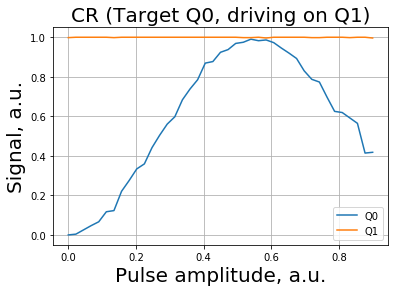

In [43]:
drive_idx = 1
target_idx = 0
flip_drive = True

cr_rabi_qobj = assemble(cr_drive_experiments(drive_idx, target_idx, flip_drive),
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg',
                        shots=shots)

sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, cr_drive_amps, sim_result)

Observe that now qubit 1 is in the excited state, while oscillations are again being driven on qubit 0, now at a different rate as before.

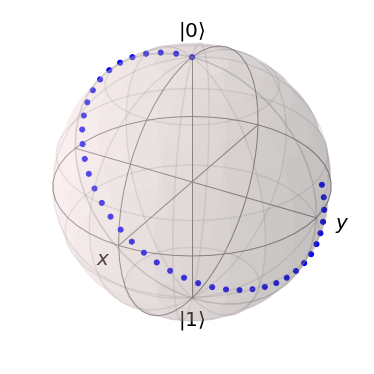

In [44]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

Observe now that qubit 1 takes a different trajectory on the bloch sphere.